In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict
import matplotlib.ticker as ticker

from utils import *

In [2]:
# plt.rcParams["legend.title_fontsize"] = "xx-large"
plt.rcParams.update({'font.size': 20})

matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [4]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    elif config['agent']['agent_name'] == 'gciql_search':
        result += "GCIQL"
    else:
        result += "CRL"

    if config['agent']['is_td']:
        result += ' TD'
    else:
        result += ' MC'

    if config['agent']['net_arch'] =='mlp':
        result += ' SMALL'
    else:
        result += ' BIG'


    return result

agents = ['GCDQN', 'C-LEARN', 'CRL', 'GCIQL']
grid_sizes = [4,5]

possible_names = ["GCDQN MC", 
                  "GCDQN TD", 
                  "C-LEARN MC", 
                  "C-LEARN TD",
                  "CRL MC",
                  "GCIQL TD",
                  "GCIQL MC",]


possible_names_small = [name + " SMALL" for name in possible_names]
possible_names_big = [name + " BIG" for name in possible_names]


for grid_size in grid_sizes:

    config_1 = {
        "directory": "generalized_curves",
        "title": f"scaling_generalized_train_3_boxes_2_movable_{grid_size}_grid_curve_small",
        "projects":["paper_generalized"],
        "possible_names":possible_names_small,
        "filters":{
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
            "config.agent.net_arch": 'mlp',
            "tags":{"$nin":["mc_old_gamma"]},
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"),
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }

    config_2 = {
        "directory": "generalized_curves",
        "title": f"scaling_generalized_train_3_boxes_2_movable_{grid_size}_grid_curve_big",
        "projects":["paper_generalized"],
        "possible_names":possible_names_big,
        "filters":{
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
            "config.agent.net_arch": 'res_block',
            "tags":{"$nin":["mc_old_gamma"]},
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"),
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }


    all_configs.extend([config_1, config_2])


# Plotting

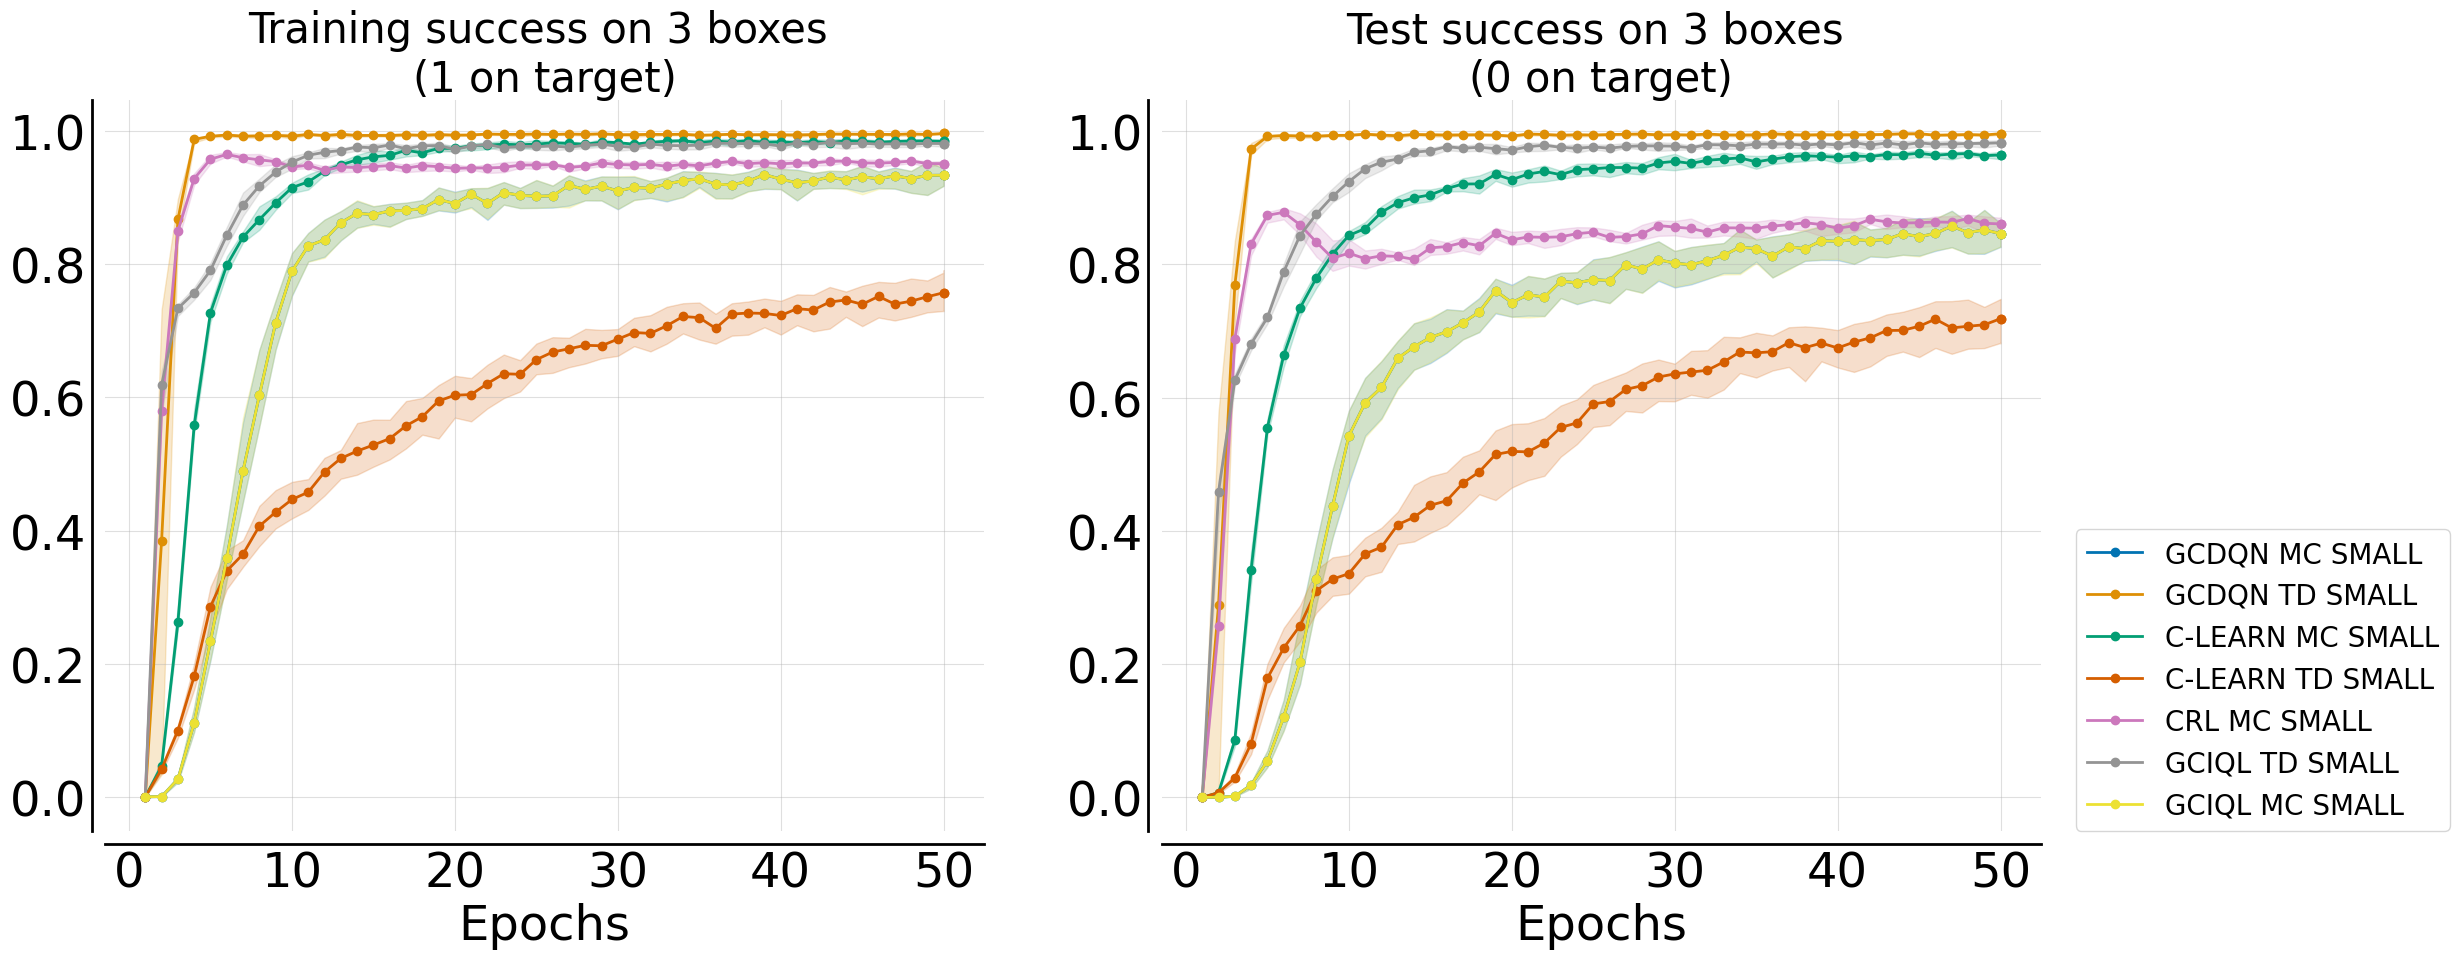

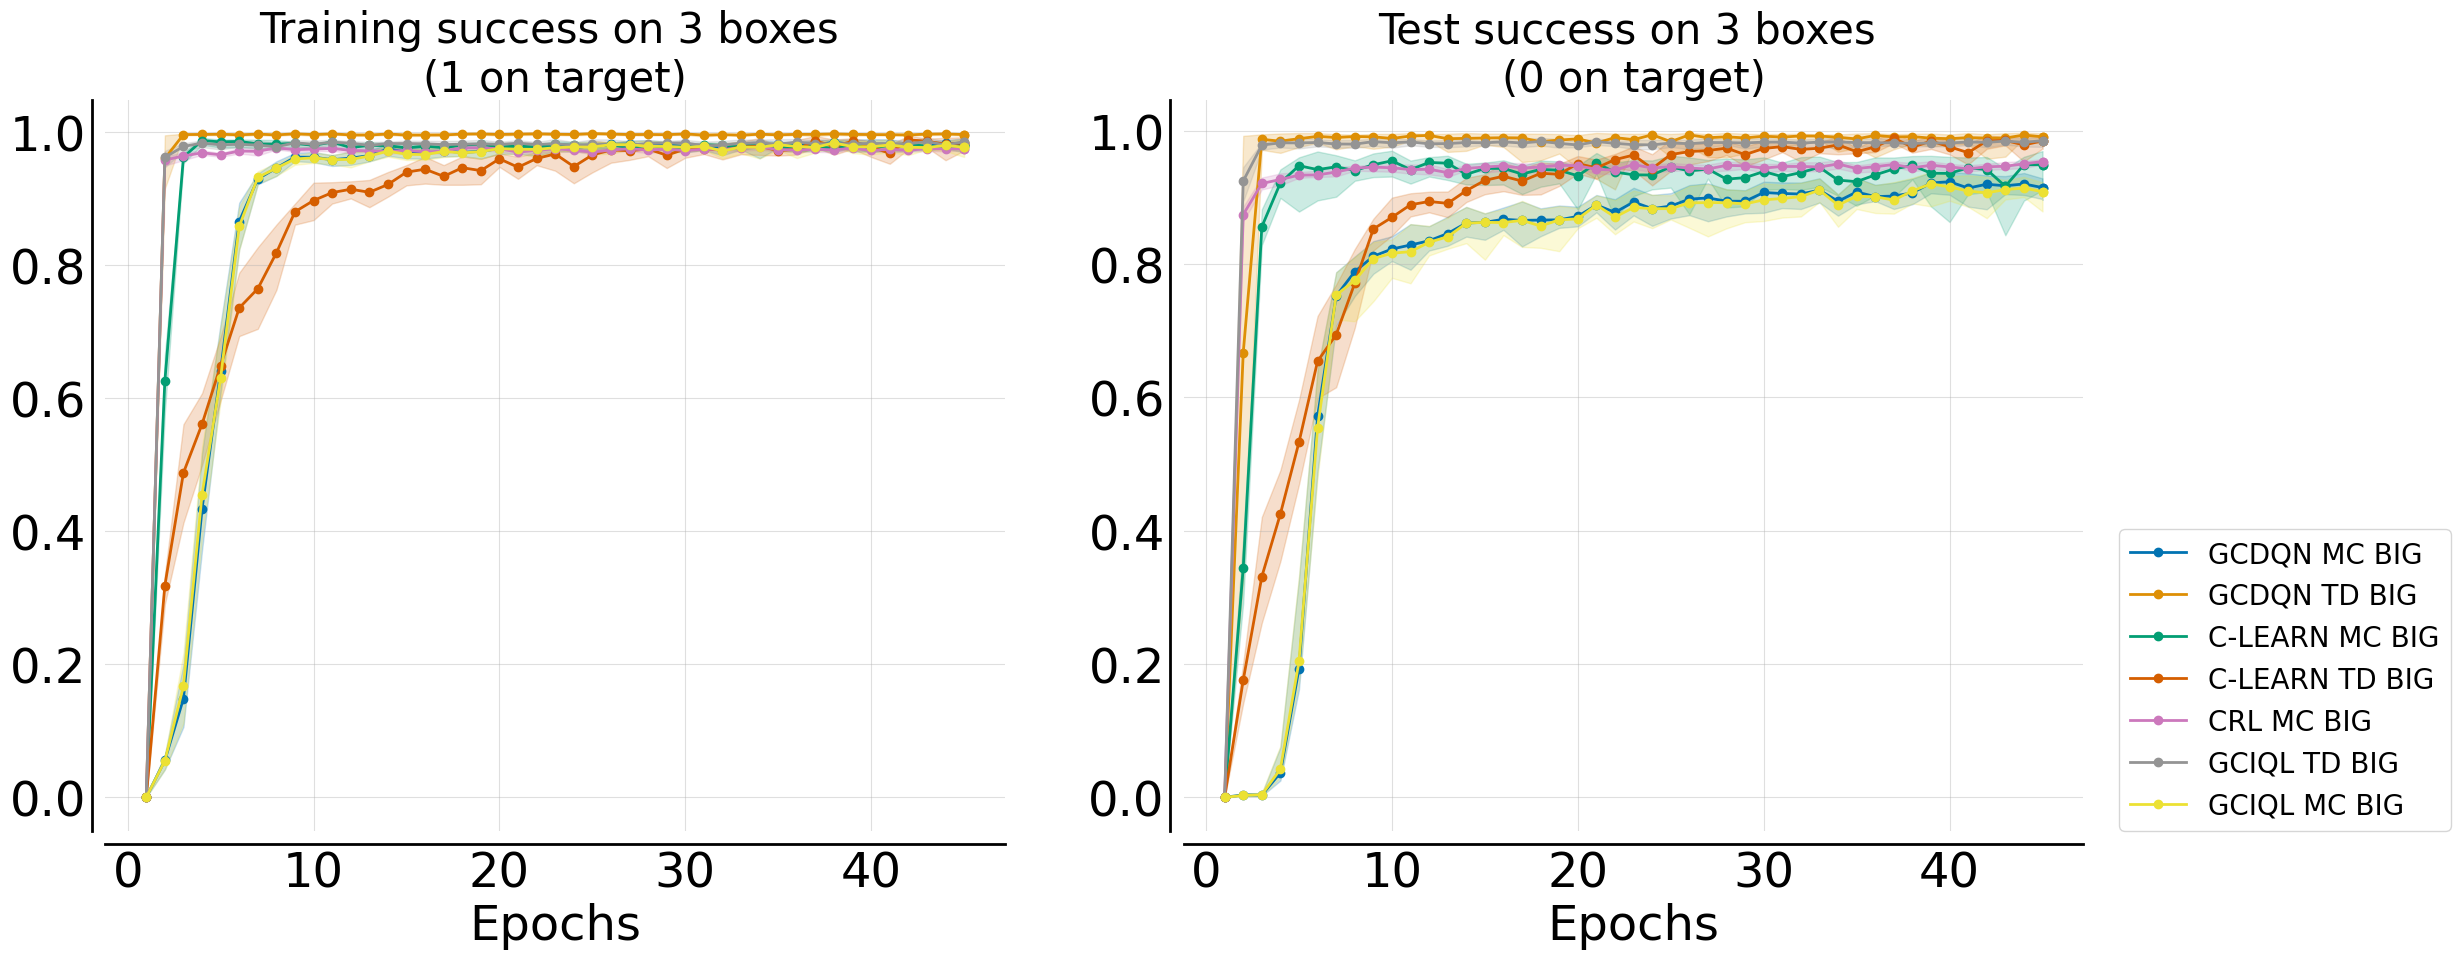

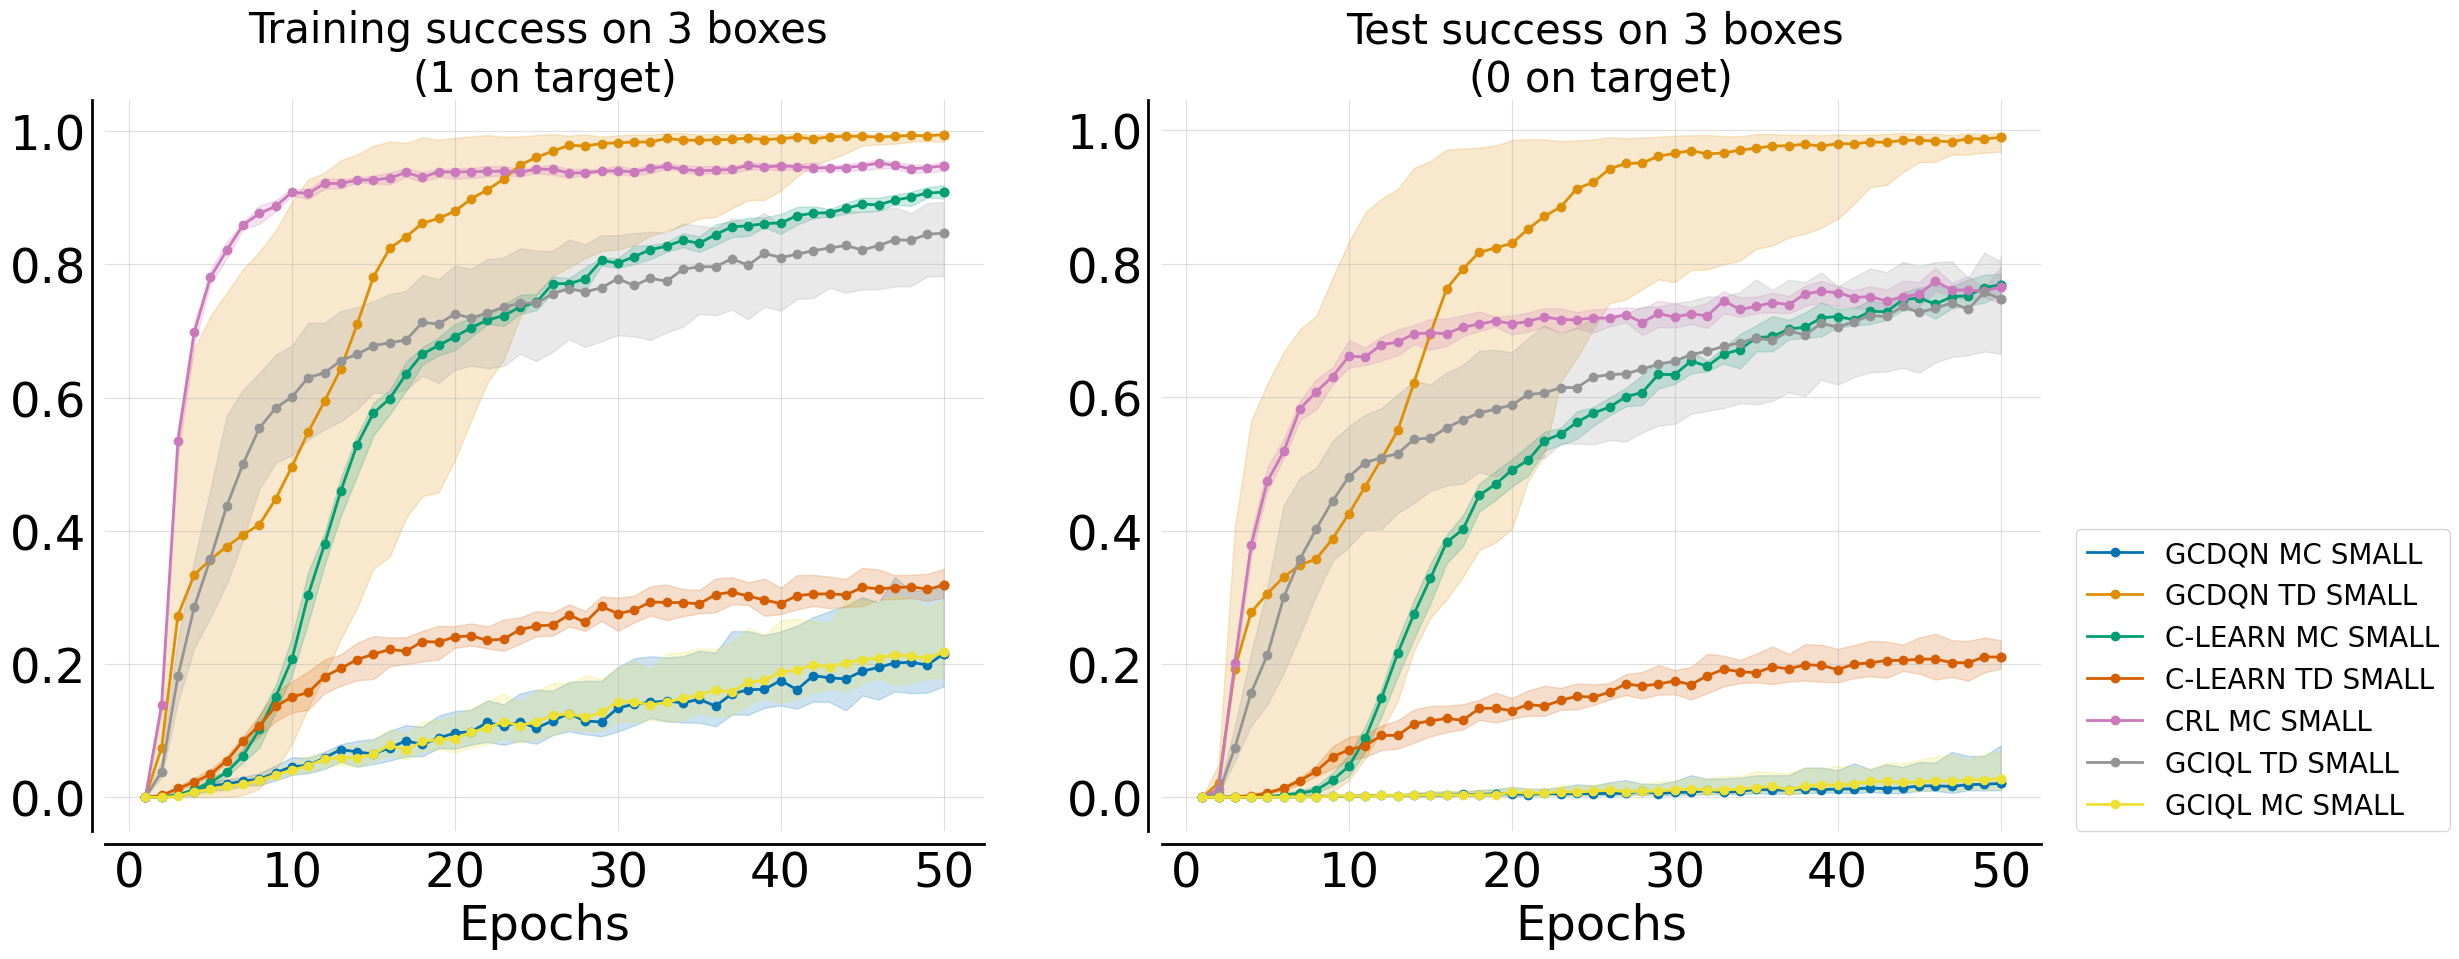

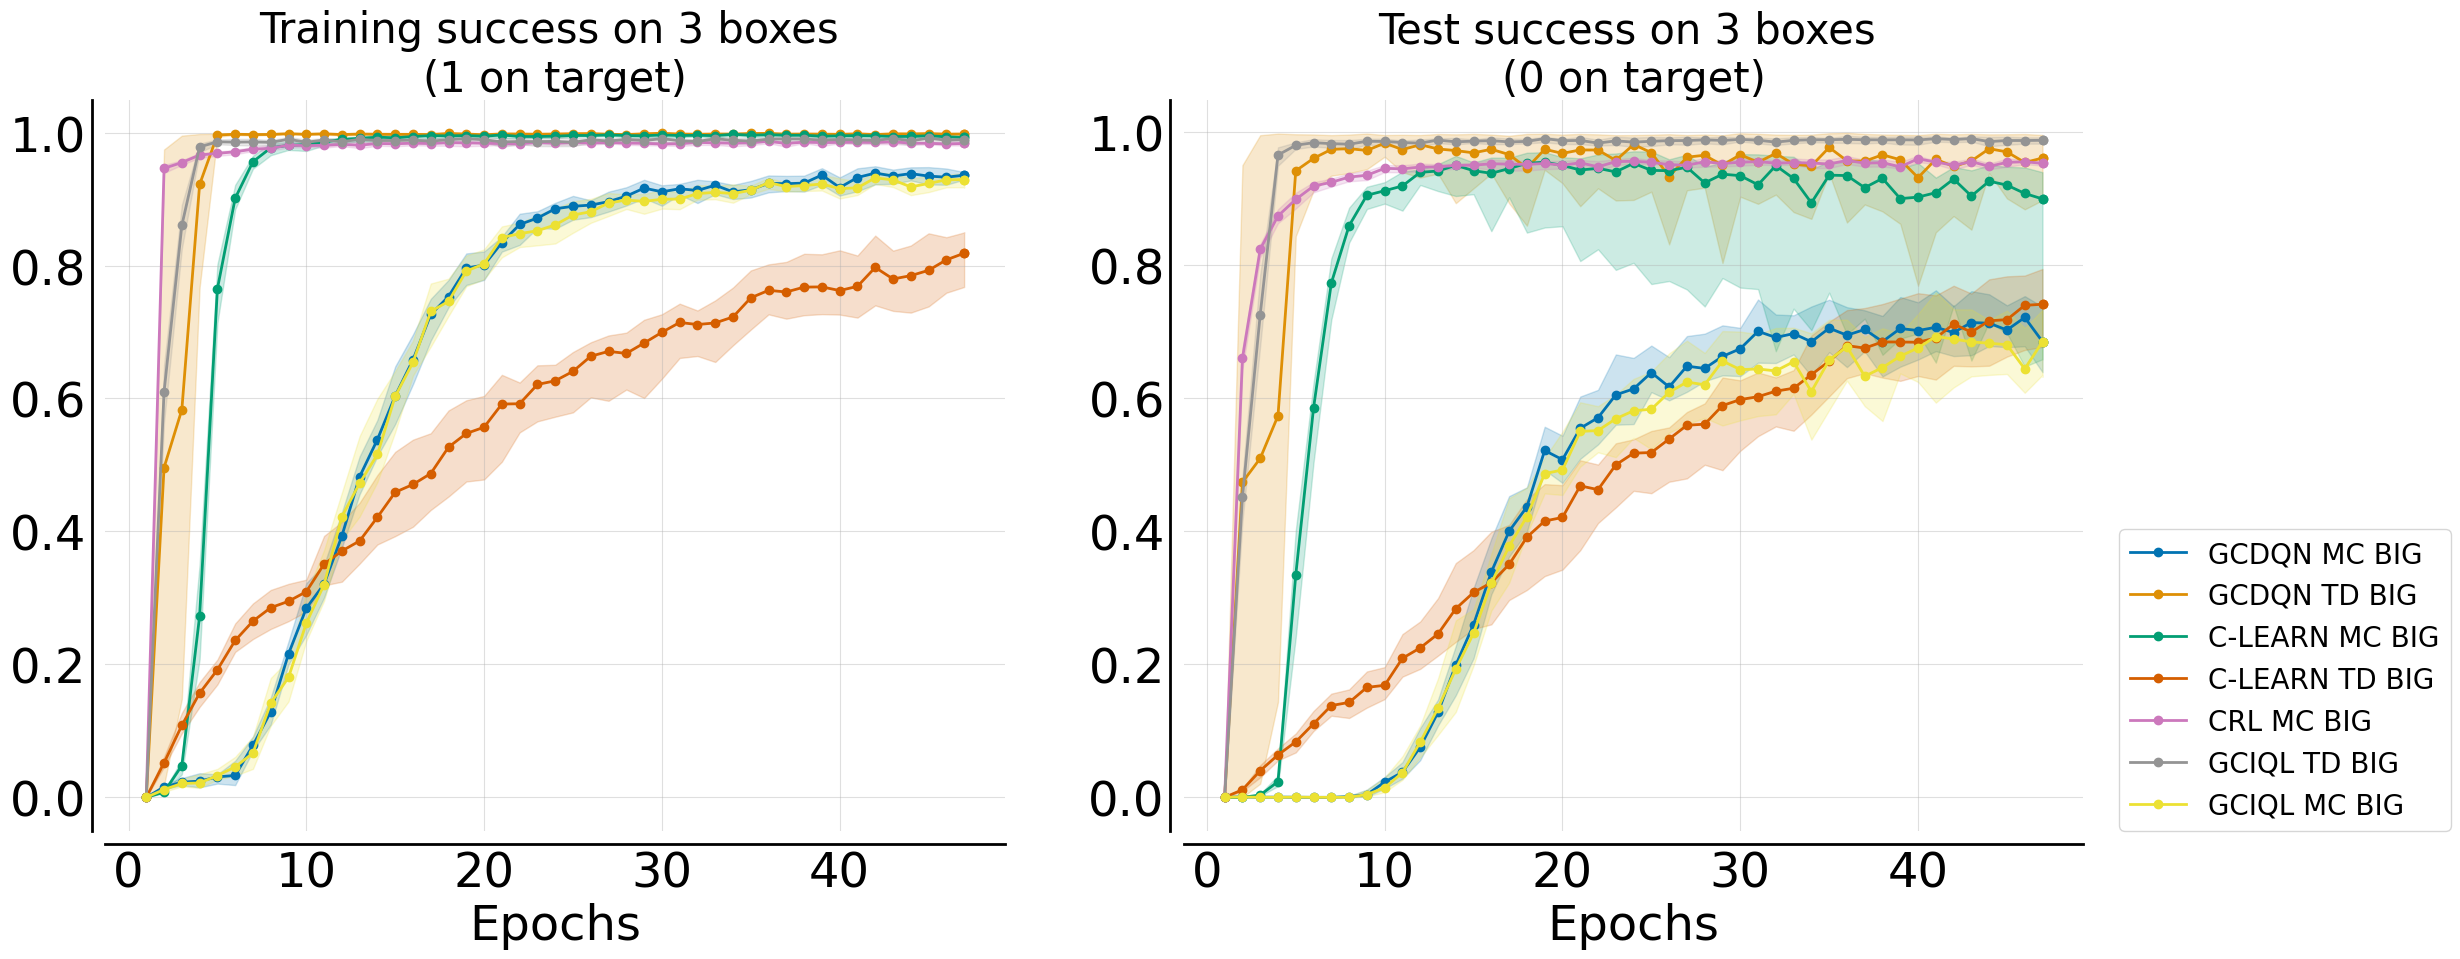

In [5]:

for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k] = aggregated_v[:].reshape(-1, 1)
        # new_data[k + ' train'] = aggregated_v[:, 0].reshape(-1, 1)

    keys_to_del = []


    for k in keys_to_del:
        del new_data[k]


    names = list(new_data.keys())

    metrics_names = config['metrics']

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])


    # fig, ax = plt.subplots()
    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )

    draw_curves_plot(data_curves, config['possible_names'], config['metrics'], config['title'] + "_curves", figures_path=path)


    